In [2]:
import pandas as pd 
import numpy as np
bank_data = pd.read_csv('bank-additional-full.csv',sep = ';' )

campaign = 活動期間聯絡次數
previous = 活動前跟銀行往來的次數(0 = 沒有往來過)
poutcome = 之前的行銷活動結果，分為成功、失敗、新客戶

資料清洗

In [5]:
#資料後半部都是經濟指標，暫不列入分析，予以刪除
df = bank_data.drop(columns = ['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'])
#刪除最後一次聯繫為星期幾、幾月、聯繫時的電話時長、自上次活動後，多久沒聯絡、
df = df.drop(columns = ['day_of_week','month','duration','pdays'])
#修改一些欄位名稱，能更直觀知道欄位意思
df = df.rename(columns = {'campaign': 'contact_count','y':'time_deposit'}) 
df

,age,job,marital,education,default,housing,loan,contact,contact_count,previous,poutcome,time_deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,1,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,1,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,1,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,1,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,1,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,1,0,nonexistent,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,1,0,nonexistent,no
41185,56,retired,married,university.degree,no,yes,no,cellular,2,0,nonexistent,no
41186,44,technician,married,professional.course,no,no,no,cellular,1,0,nonexistent,yes


In [6]:
for col in df.columns :
    print(f'{col} : {df[col].unique()}')

age : [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital : ['married' 'single' 'divorced' 'unknown']
education : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default : ['no' 'unknown' 'yes']
housing : ['no' 'yes' 'unknown']
loan : ['no' 'yes' 'unknown']
contact : ['telephone' 'cellular']
contact_count : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
previous : [0 1 2 3 4 5 6 7]
poutcome : ['nonexistent' 'failure' 'success']
time_deposit : ['no' 'yes']


In [7]:
#將占比很少的unknown(5%以下)併入到該變數的眾數，較多unknown的變數不列入，且做特殊標記
unknown_list = ['marital','default','loan','job','education','housing']
for col in unknown_list:
   if 'unknown' in df[col].values:
       total = len(df[col])
       unknown_count = (df[col] == 'unknown').sum()
       unknown_ratio = unknown_count / total
       if unknown_ratio < 0.05:
           mode_value = df.loc[df[col] != 'unknown',col ].mode()[0]
           df[col] = df[col].replace('unknown',mode_value)
           print(f"{col}: 將unknown 併入眾數 '{mode_value}'")
       else:
            print(f"{col}: 保留 unknown")

marital: 將unknown 併入眾數 'married'
default: 保留 unknown
loan: 將unknown 併入眾數 'no'
job: 將unknown 併入眾數 'admin.'
education: 將unknown 併入眾數 'university.degree'
housing: 將unknown 併入眾數 'yes'


In [8]:
#將年齡分區間
age_1 = [0,20,30,40,50,60,100]
age_label = ['<20','21-30','31-40', '41-50', '51-60' ,'>60' ]
df['age_group'] = pd.cut(df['age'], bins = age_1 , labels = age_label)
#將欄位只有yes、no的欄位內容改成0、1(0 = no , 1 = yes)
df['time_deposit'] = df['time_deposit'].map({'no': 0,'yes': 1})
df['loan'] = df['loan'].map({'no': 0 ,'yes' : 1})
df['housing'] = df['housing'].map({'no':0 ,'yes' : 1})
#新增新/舊客戶欄位(將previous分成 = 0 或 >0的欄位)
def customer(counts):
    if counts <= 0:
        return 0
    else :
        return 1
df['new_customer'] = df['previous'].apply(customer)
#新增聯絡次數分組(分為1、2、3、4跟>=5的組別)
df['contact_group'] = np.where( df['contact_count']>= 5 , 5 ,df['contact_count'].astype(int))
df

,age,job,marital,education,default,housing,loan,contact,contact_count,previous,poutcome,time_deposit,age_group,new_customer,contact_group
0,56,housemaid,married,basic.4y,no,0,0,telephone,1,0,nonexistent,0,51-60,0,1
1,57,services,married,high.school,unknown,0,0,telephone,1,0,nonexistent,0,51-60,0,1
2,37,services,married,high.school,no,1,0,telephone,1,0,nonexistent,0,31-40,0,1
3,40,admin.,married,basic.6y,no,0,0,telephone,1,0,nonexistent,0,31-40,0,1
4,56,services,married,high.school,no,0,1,telephone,1,0,nonexistent,0,51-60,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,1,0,cellular,1,0,nonexistent,1,>60,0,1
41184,46,blue-collar,married,professional.course,no,0,0,cellular,1,0,nonexistent,0,41-50,0,1
41185,56,retired,married,university.degree,no,1,0,cellular,2,0,nonexistent,0,51-60,0,2
41186,44,technician,married,professional.course,no,0,0,cellular,1,0,nonexistent,1,41-50,0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            41188 non-null  int64   
 1   job            41188 non-null  object  
 2   marital        41188 non-null  object  
 3   education      41188 non-null  object  
 4   default        41188 non-null  object  
 5   housing        41188 non-null  int64   
 6   loan           41188 non-null  int64   
 7   contact        41188 non-null  object  
 8   contact_count  41188 non-null  int64   
 9   previous       41188 non-null  int64   
 10  poutcome       41188 non-null  object  
 11  time_deposit   41188 non-null  int64   
 12  age_group      41188 non-null  category
 13  new_customer   41188 non-null  int64   
 14  contact_group  41188 non-null  int32   
dtypes: category(1), int32(1), int64(7), object(6)
memory usage: 4.3+ MB


探索性分析
每個變數對定存的對比

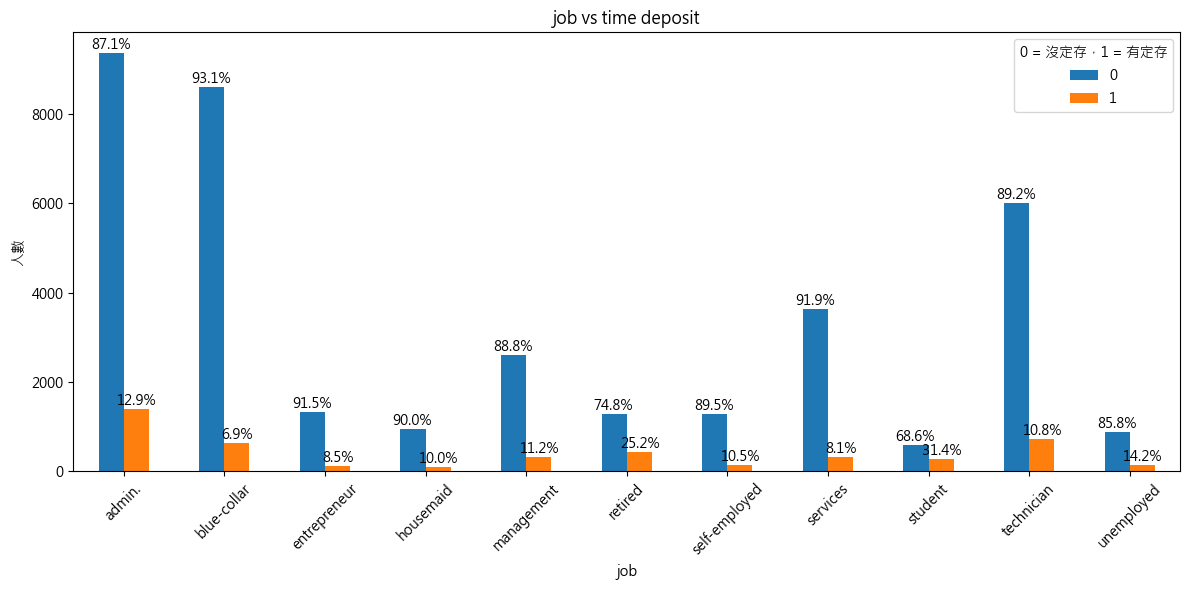

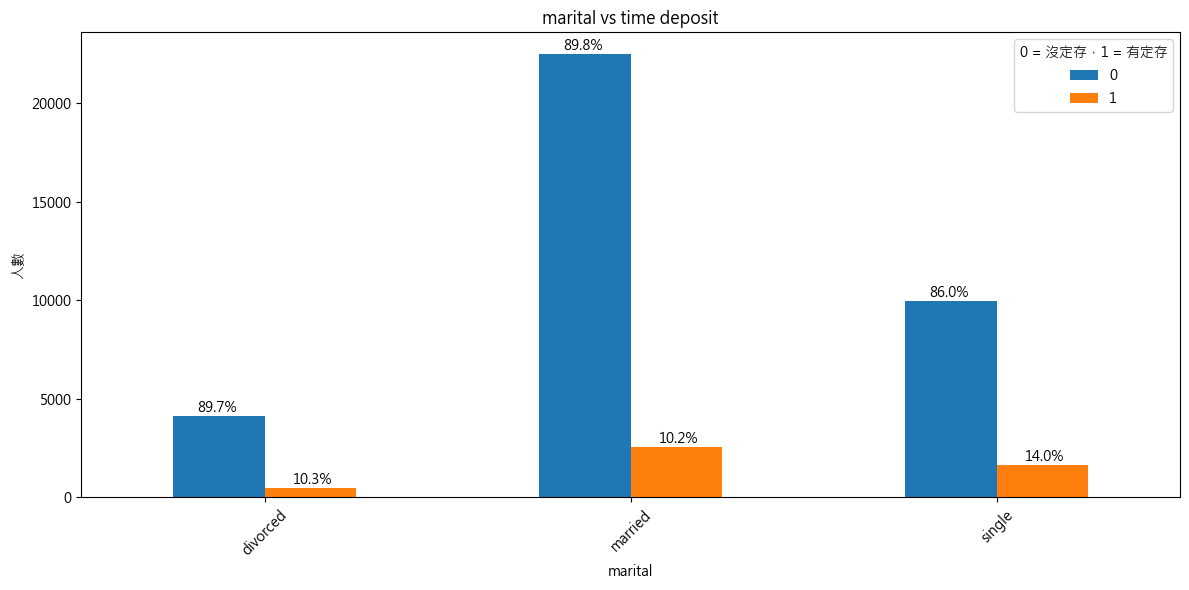

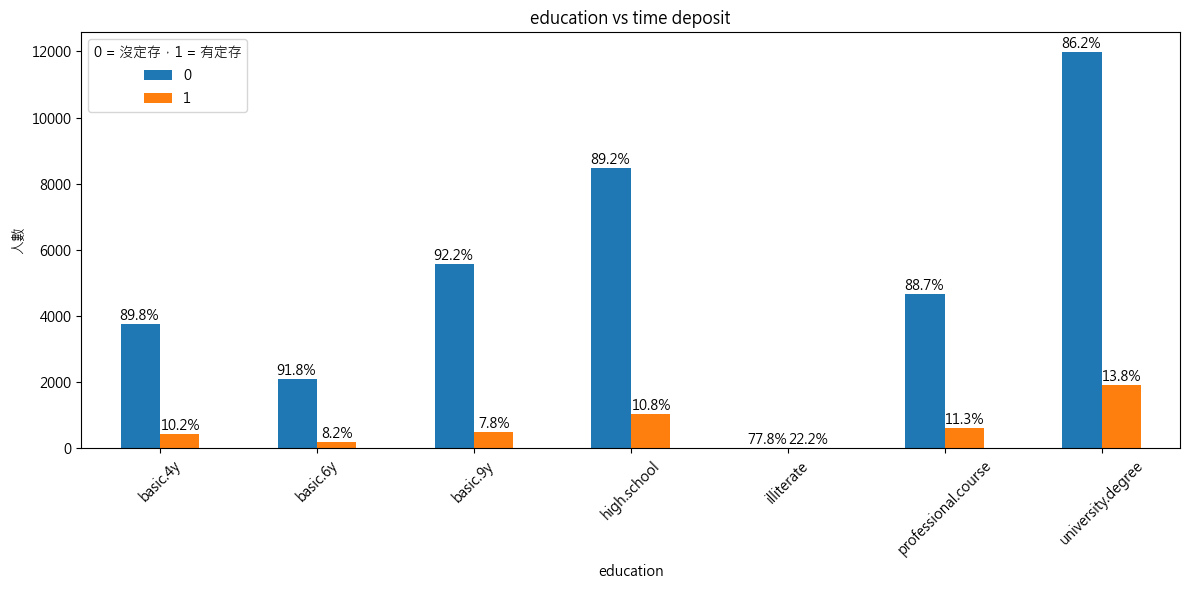

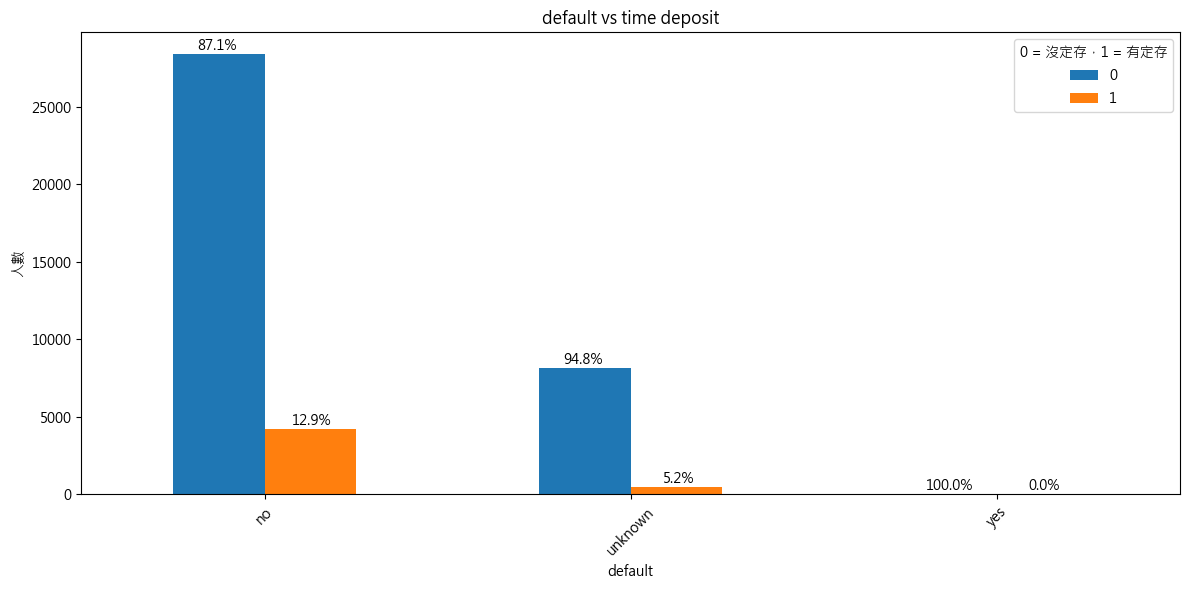

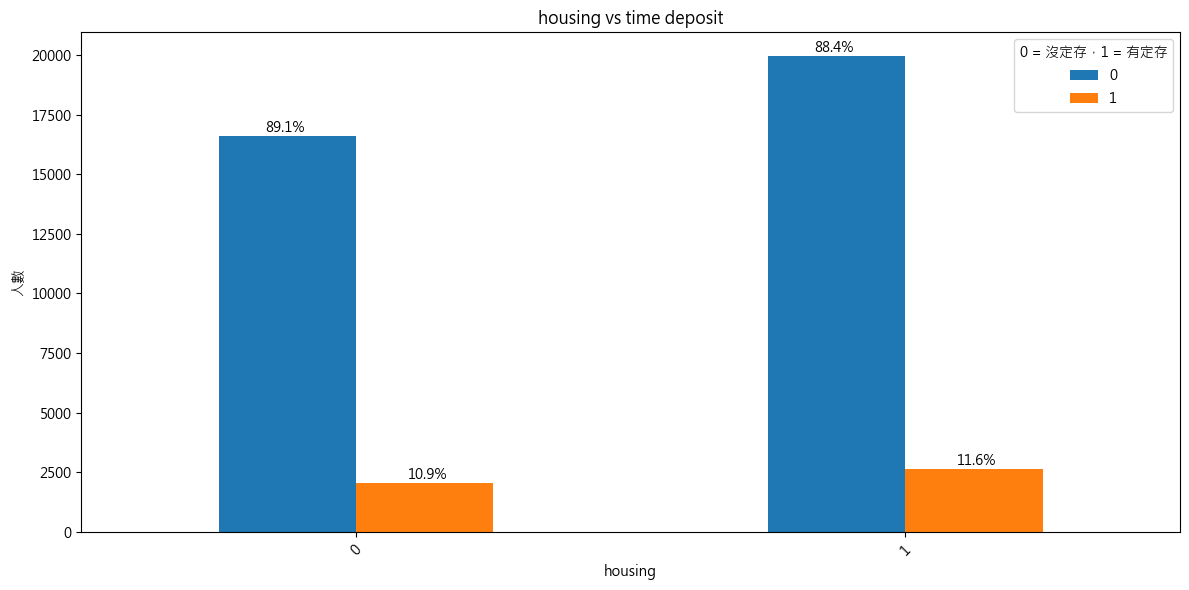

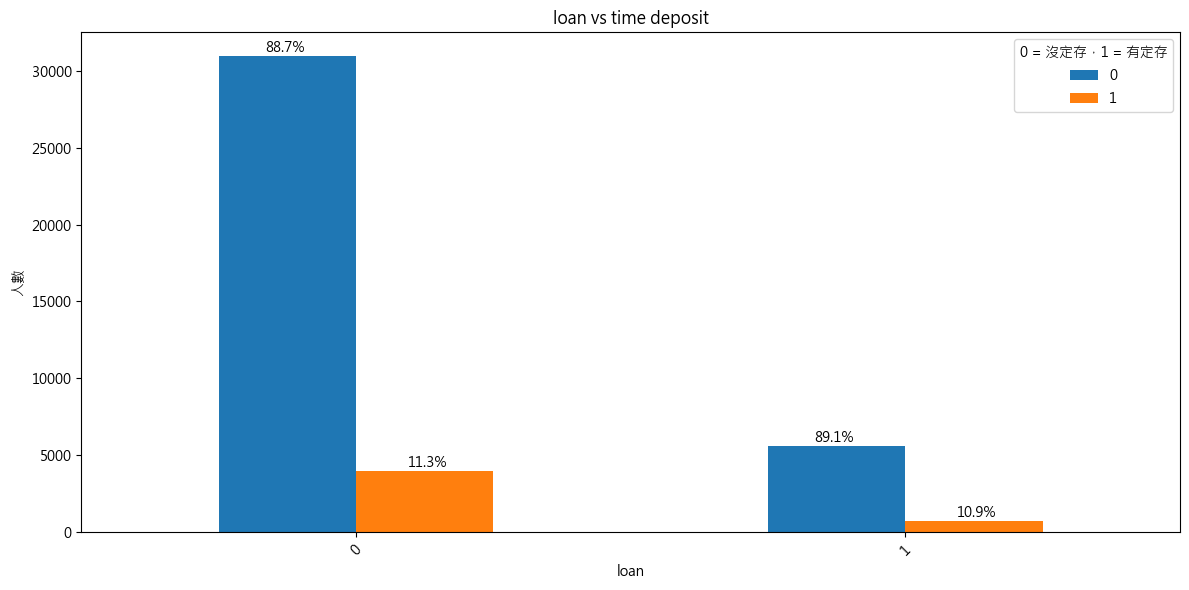

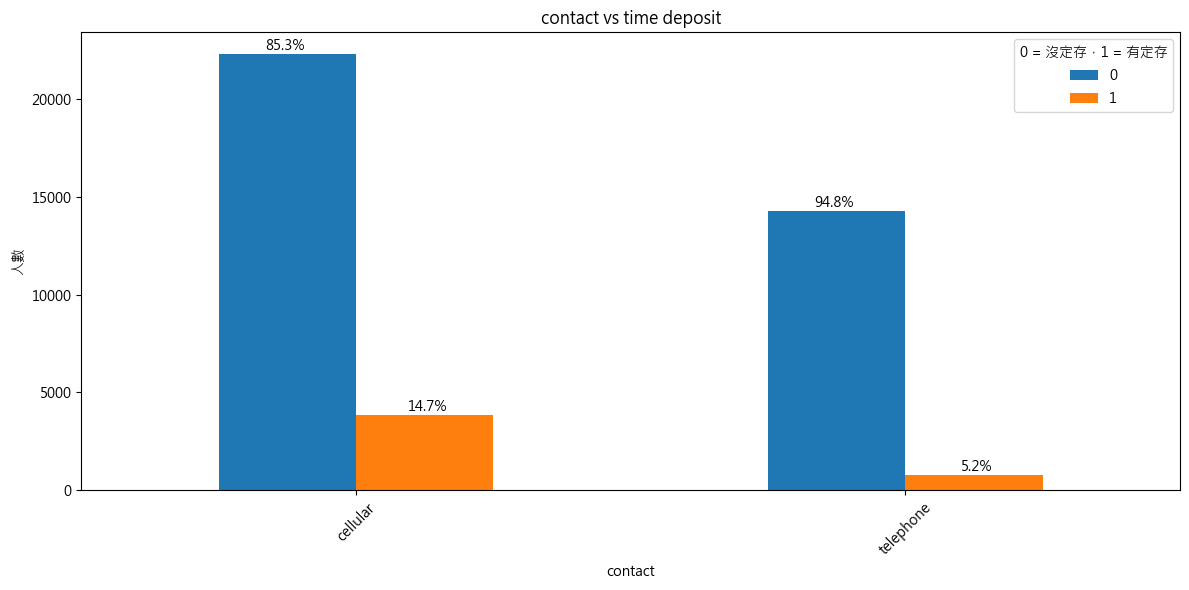

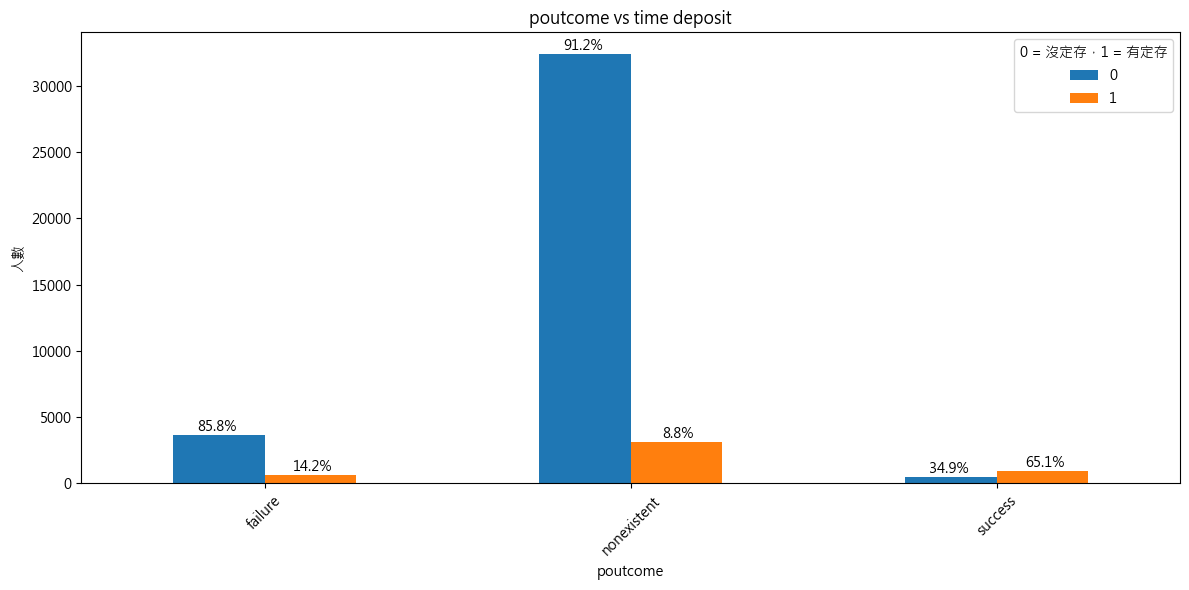

C:\Users\rine2\AppData\Local\Temp\ipykernel_10352\1824713225.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby([var,'time_deposit']).size().unstack(fill_value = 0)


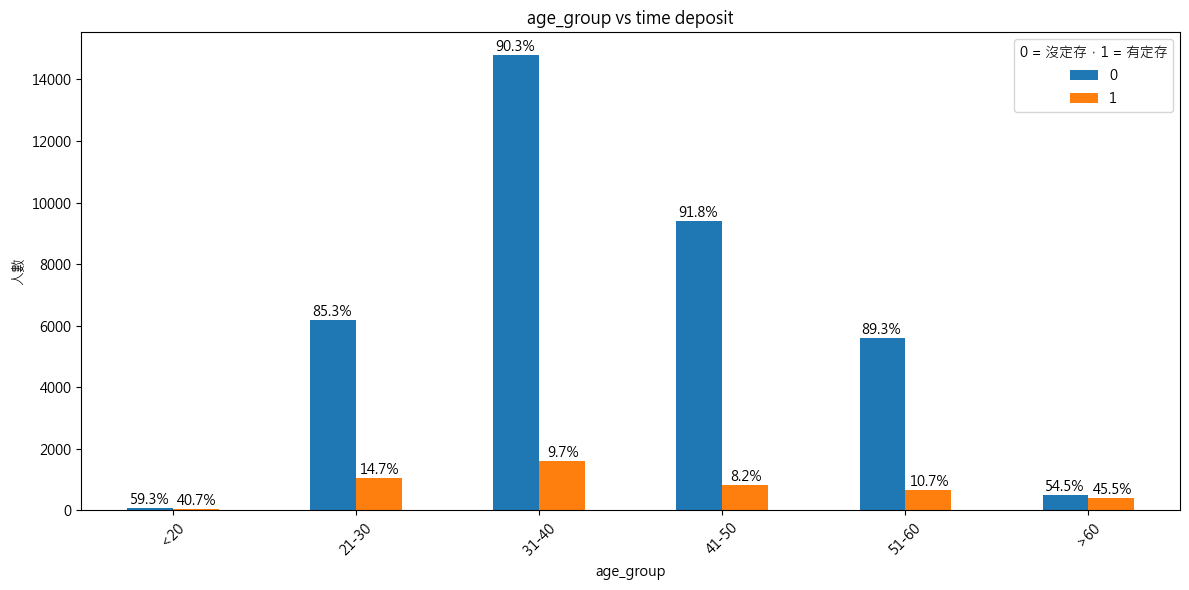

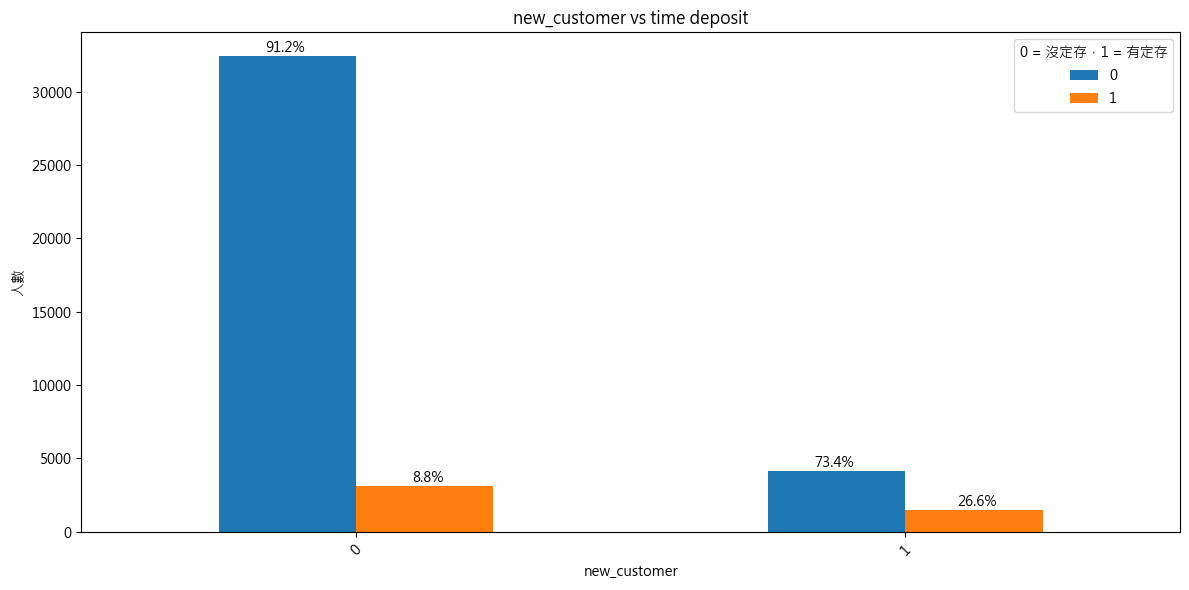

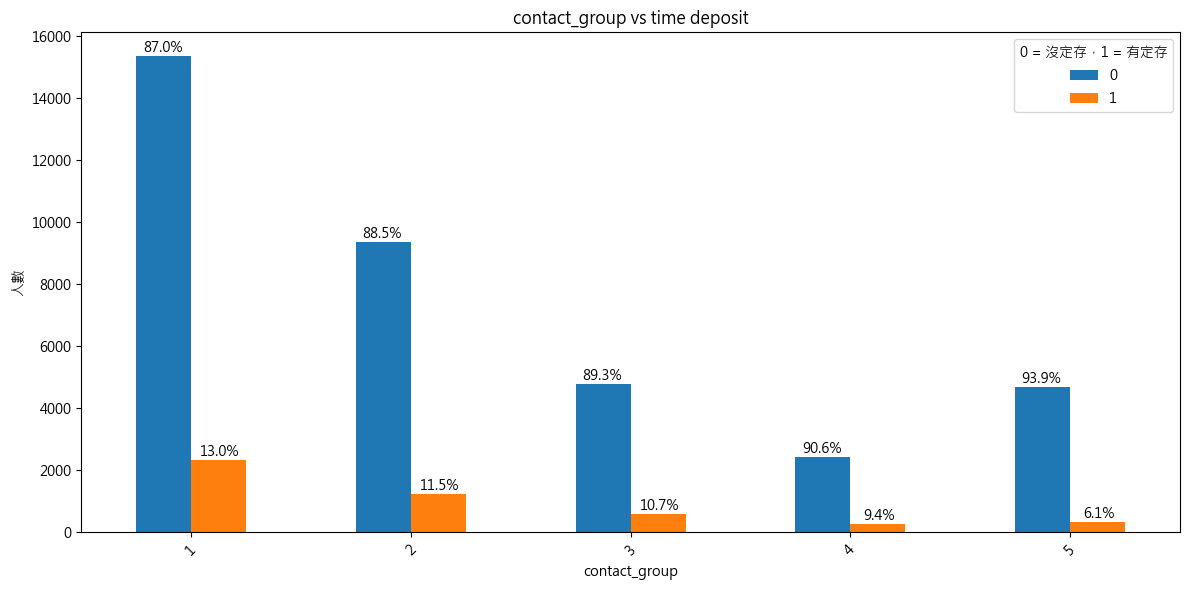

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

#設定圖表中文字形
rcParams['font.family'] = ['Microsoft JhengHei','sans serif']
#使用正確的負號
rcParams['axes.unicode_minus'] = False

exclude  = ['age','contact_count','previous','time_deposit']
cols = [col for col in df.columns if col not in exclude]
for var in cols:
    group = df.groupby([var,'time_deposit']).size().unstack(fill_value = 0)
    ax = group.plot(kind = 'bar',stacked = False , figsize = (12,6))
    success_rate = group[1] / (group[0] + group[1])
    for i ,(name,rate) in enumerate(success_rate.items()):
        height = group.loc[name,1]
        ax.text(i + 0.13 ,height,f'{rate:.1%}',ha = 'center',va = 'bottom',fontsize = 10)
        fail_height = group.loc[name,0]
        ax.text(i - 0.13,fail_height , f'{1-rate:.1%}',ha = 'center', va = 'bottom',fontsize = 10)
    plt.title(f'{var} vs time deposit')
    plt.xlabel(f'{var}')
    plt.ylabel('人數')
    plt.xticks(rotation = 45)
    plt.legend(title = '0 = 沒定存，1 = 有定存')
    plt.tight_layout()
    plt.savefig(f'{var} vs time_deposit')
    plt.show()

統計分析
先做各變數對定存的卡方檢定，再做邏輯斯回歸報告看p值

In [13]:
#各變數的卡方檢定
from scipy.stats import chi2_contingency
exclude_table = ['age','time_deposit','default_is_unknown','previous','contact_count']

tables = [table for table in df.columns if table not in exclude_table]
for v in tables:
    v_table = pd.crosstab(df[v],df['time_deposit'])
    chi2_v,p_v,dof_v,expected_v = chi2_contingency(v_table)
    print(f'{v} vs time deposit')
    print(f'Chi - square 統計量 : {chi2_v:.4f}')
    print(f'自由度 : {dof_v}')
    print(f'p值 : {p_v:.2e}')
    if p_v < 0.05:
        print(f'{v}對定存有顯著關聯')
    else:
        print(f'{v}對定存沒有顯著關聯')
    a = v_table.sum().sum()
    min_dim = min(v_table.shape)-1
    cramers_v = np.sqrt(chi2_v/(min_dim*a))
    print(f"Carmer's V :{cramers_v:.4f}")
    print()

job vs time deposit
Chi - square 統計量 : 960.2507
自由度 : 10
p值 : 6.81e-200
job對定存有顯著關聯
Carmer's V :0.1527

marital vs time deposit
Chi - square 統計量 : 120.7843
自由度 : 2
p值 : 5.92e-27
marital對定存有顯著關聯
Carmer's V :0.0542

education vs time deposit
Chi - square 統計量 : 192.1936
自由度 : 6
p值 : 8.69e-39
education對定存有顯著關聯
Carmer's V :0.0683

default vs time deposit
Chi - square 統計量 : 406.5775
自由度 : 2
p值 : 5.16e-89
default對定存有顯著關聯
Carmer's V :0.0994

housing vs time deposit
Chi - square 統計量 : 4.9910
自由度 : 1
p值 : 2.55e-02
housing對定存有顯著關聯
Carmer's V :0.0110

loan vs time deposit
Chi - square 統計量 : 0.7826
自由度 : 1
p值 : 3.76e-01
loan對定存沒有顯著關聯
Carmer's V :0.0044

contact vs time deposit
Chi - square 統計量 : 862.3184
自由度 : 1
p值 : 1.53e-189
contact對定存有顯著關聯
Carmer's V :0.1447

poutcome vs time deposit
Chi - square 統計量 : 4230.5238
自由度 : 2
p值 : 0.00e+00
poutcome對定存有顯著關聯
Carmer's V :0.3205

age_group vs time deposit
Chi - square 統計量 : 1413.1392
自由度 : 5
p值 : 1.96e-303
age_group對定存有顯著關聯
Carmer's V :0.1852

new_custome

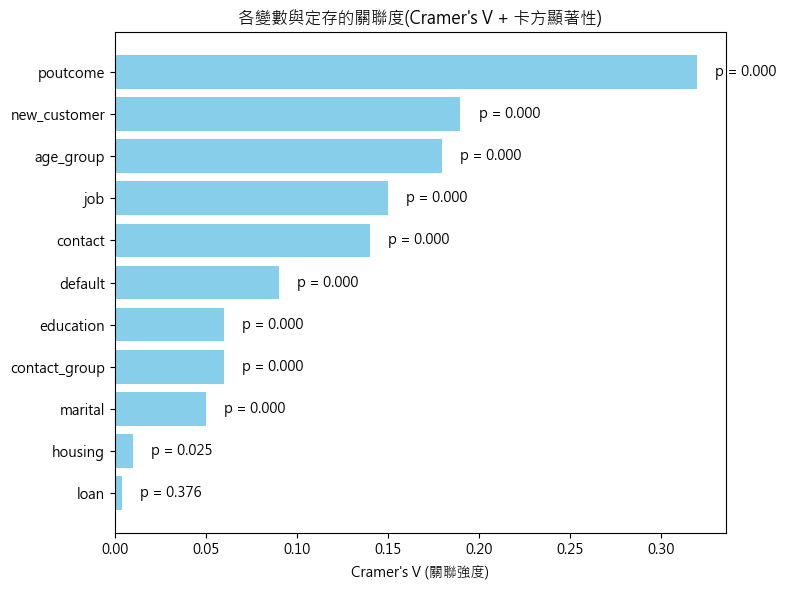

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
#cramers_v 跟卡方結果
cramers_v_result = {
    'job': 0.15,
    'marital': 0.05,
    'education': 0.06,
    'default': 0.09,
    'housing': 0.01,
    'loan': 0.004,
    'contact': 0.14,
    'poutcome': 0.32,
    'age_group': 0.18,
    'new_customer': 0.19,
    'contact_group': 0.06
}
chi2_p_values = {
    'job': 6.81e-200,
    'marital': 5.92e-27,
    'education': 8.69e-39,
    'default':  5.16e-89,
    'housing':  2.55e-02,
    'loan': 3.76e-01,
    'contact':  1.53e-189,
    'poutcome': 0.00e+00,
    'age_group':1.96e-303,
    'new_customer':0.00e+00,
    'contact_group': 1.29e-41
}
#轉成 dataframe
a_table = pd.DataFrame({
    "Variable":cramers_v_result.keys(),
    "Cramer's V":cramers_v_result.values(),
    "p value":[chi2_p_values[v] for v in cramers_v_result.keys()]
})
#排序
a_table = a_table.sort_values(by = "Cramer's V",ascending = False)
#畫圖
plt.figure(figsize = (8,6))
bars = plt.barh(a_table['Variable'],a_table["Cramer's V"],color = 'skyblue')
#標註 p-value 跟星號
for bar,p in zip (bars,a_table["p value"]):
    plt.text(bar.get_width() + 0.01,bar.get_y() + bar.get_height()/2,
            f"p = {p:.3f} ",va = 'center')
plt.xlabel("Cramer's V (關聯強度)")
plt.title("各變數與定存的關聯度(Cramer's V + 卡方顯著性)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("各變數與定存的關聯度(Cramer's V + 卡方顯著性)")
plt.show()


In [15]:
#各變數的邏輯斯回歸報告
import statsmodels.formula.api as smf
exclude_model = ['age','time_deposit','previous','contact_count']
models = [model for model in df.columns if model not in exclude_model ]
for m in models:
    m_model = smf.logit(f"time_deposit ~ C({m})",data = df).fit()
    print(f'{m} vs time_deposit')
    print(m_model.summary())

Optimization terminated successfully.
         Current function value: 0.342181
         Iterations 7
job vs time_deposit
                           Logit Regression Results                           
Dep. Variable:           time_deposit   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41177
Method:                           MLE   Df Model:                           10
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                 0.02797
Time:                        00:18:50   Log-Likelihood:                -14094.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                8.039e-168
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.9082      0.029    -66.364      

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.351967
         Iterations 6
housing vs time_deposit
                           Logit Regression Results                           
Dep. Variable:           time_deposit   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41186
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:               0.0001749
Time:                        00:18:51   Log-Likelihood:                -14497.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                   0.02433
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.1031      0.024    -89.365      0.000      -2.149   

模型建模
為了找出對定存影響較大的變數，因此先用隨機森林、XGBoost、邏輯斯回歸建模
找出前幾名重要變數後，再丟入邏輯斯回歸模型看係數

In [17]:
#交叉驗證迴圈建模
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score,accuracy_score ,f1_score,classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,make_scorer
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE

#定義模型建模
def train_model (x,y,model_name = 'RandomForest',cv_folds = 5,use_smote = False):
    if model_name == 'RandomForest':
        model = RandomForestClassifier(random_state = 42)
    elif model_name == 'XGBoost':
        model = XGBClassifier(random_state = 42,eval_metric = 'mlogloss')
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(random_state = 42,max_iter = 1000)
    else:
        raise ValueError('模型名稱錯誤，請使用隨機森林、XGBoost、Logistic Regression模型中的一個')
    cv = StratifiedKFold(n_splits = cv_folds, shuffle = True,random_state = 42)
    accuracy = []
    precision = []
    recall = []
    f1_scores = []
    for train_idx , test_idx in cv.split(x,y):
        x_train,x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train,y_test = y.iloc[train_idx], y.iloc[test_idx]
        if use_smote:
            sm = SMOTE(random_state = 42)
            x_train,y_train = sm.fit_resample(x_train,y_train)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)

        accuracy.append(accuracy_score(y_test,y_pred))
        precision.append(precision_score(y_test,y_pred,average = 'macro',zero_division = 0))
        recall.append(recall_score(y_test,y_pred,average = 'macro',zero_division = 0))
        f1_scores.append(f1_score(y_test,y_pred,average = 'macro',zero_division = 0))
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 1/cv_folds,random_state = 42,stratify = y)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    result = {
        'model':model,
        'presicion_mean':np.mean(precision),
        'recall_mean':np.mean(recall),
        'f1_score_mean':np.mean(f1_scores),
        'accuracy_mean':np.mean(accuracy),
        'report':classification_report(y_test,y_pred,zero_division = 0)
    }
    return result


Random Forest report : 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.48      0.21      0.29       928

    accuracy                           0.89      8238
   macro avg       0.69      0.59      0.61      8238
weighted avg       0.86      0.89      0.86      8238

Random Forest 平均 precision : 0.5589
Random Forest 平均 recall : 0.6157
Random Forest 平均 f1-score : 0.5553
Random Forest 平均 accuracy : 0.7255


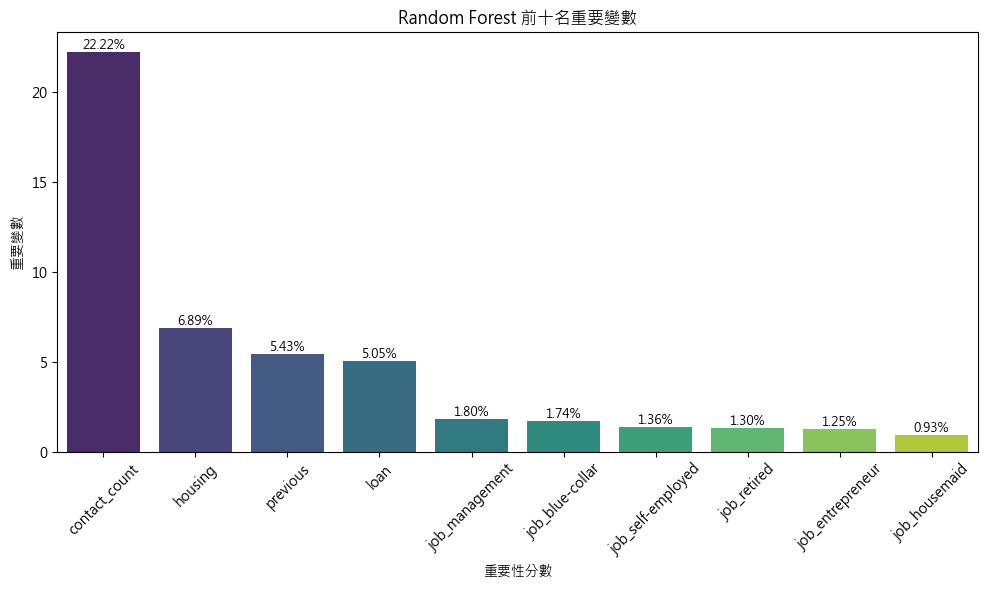

In [18]:
#隨機森林
#定義目標變數 y
y = df['time_deposit']
#設定不放入模型的變數(某些不放入的欄位是為了統計模型不要太多雜訊，而簡化的欄位，在隨機森林跟XGBoost放入原版的欄位更利於分析)
df_features = df.drop(['age','time_deposit','new_customer','contact_group'],axis = 1)
df_encoded = pd.get_dummies(df_features , drop_first = True)
x = df_encoded
random_result = train_model(x,y,model_name = 'RandomForest',use_smote = True)
print('Random Forest report : \n',random_result['report'])
print(f"Random Forest 平均 precision : {random_result['presicion_mean']:.4f}")
print(f"Random Forest 平均 recall : {random_result['recall_mean']:.4f}")
print(f"Random Forest 平均 f1-score : {random_result['f1_score_mean']:.4f}")
print(f"Random Forest 平均 accuracy : {random_result['accuracy_mean']:.4f}")

rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(x,y)
rf_importances = rf_model.feature_importances_
rf_features = pd.Series(rf_importances ,index = x.columns).head(10).sort_values(ascending = False)
rf_importance = pd.DataFrame({'Feature' : x.columns,
                              'Importance': rf_importances}).head(10).sort_values('Importance',ascending = False)
rf_importance['Importance'] = (rf_importance['Importance']*100).round(2).astype(float)
plt.figure(figsize = (10,6))
ax = sns.barplot(data = rf_importance,x = 'Feature',y = 'Importance',hue = 'Feature',palette = 'viridis',dodge = False,legend = False)
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width()/2
    ax.text(x_pos ,height ,f'{height:.2f}%',ha = 'center',va = 'bottom',fontsize = 9)
plt.title('Random Forest 前十名重要變數')
plt.xlabel('重要性分數')
plt.ylabel('重要變數')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('Random Forest 前十名重要變數')
plt.show()

In [48]:
rf_importance

,Feature,Importance
2,contact_count,22.22
0,housing,6.89
3,previous,5.43
1,loan,5.05
7,job_management,1.80
4,job_blue-collar,1.74
9,job_self-employed,1.36
8,job_retired,1.30
5,job_entrepreneur,1.25
6,job_housemaid,0.93


XGBoost report : 
               precision    recall  f1-score   support

           0       0.91      0.99      0.94      7310
           1       0.66      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.78      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238

XGBoost 平均 precision : 0.5665
XGBoost 平均 recall : 0.6327
XGBoost 平均 f1-score : 0.5637
XGBoost 平均 accuracy : 0.7273


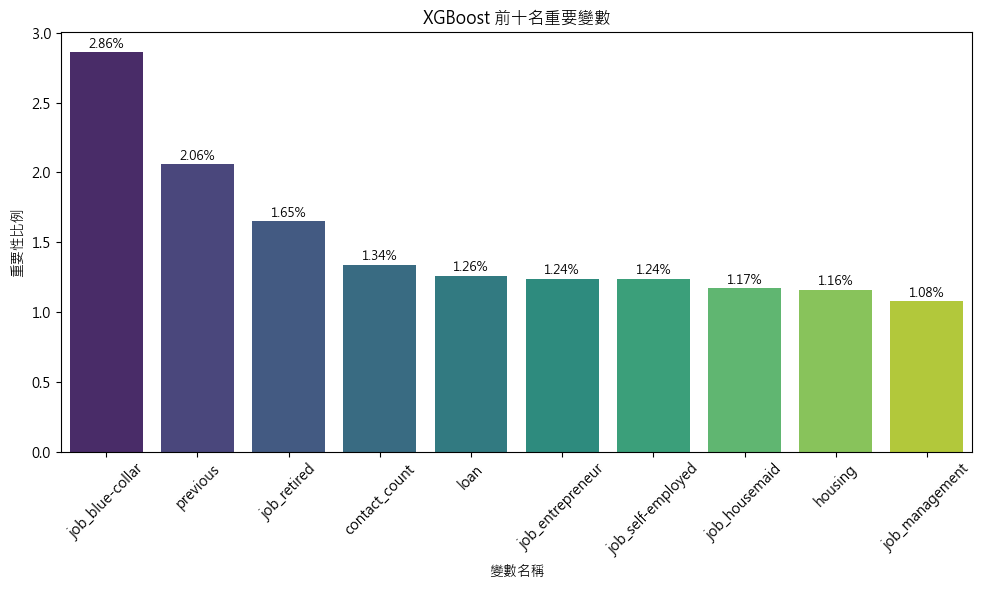

In [19]:
#XGBoost
from xgboost import plot_importance

y = df['time_deposit']
df_features = df.drop(['age','time_deposit','new_customer','contact_group'],axis = 1)
df_encoded = pd.get_dummies(df_features ,drop_first = True)
x = df_encoded
XGBoost_result = train_model(x,y,model_name = 'XGBoost',use_smote = True)
print('XGBoost report : \n',XGBoost_result['report'])
print(f"XGBoost 平均 precision : {XGBoost_result['presicion_mean']:.4f}")
print(f"XGBoost 平均 recall : {XGBoost_result['recall_mean']:.4f}")
print(f"XGBoost 平均 f1-score : {XGBoost_result['f1_score_mean']:.4f}")
print(f"XGBoost 平均 accuracy : {XGBoost_result['accuracy_mean']:.4f}")

xgb_model = XGBClassifier(random_state = 42, eval_metric = 'mlogloss')
xgb_model.fit(x,y)
importance_dict = xgb_model.get_booster().get_score(importance_type = 'gain')
importance_df = pd.DataFrame({'Feature': list(importance_dict.keys()),
                              'Importance':list(importance_dict.values())}).head(10).sort_values(by = 'Importance',ascending = False)
importance_df['Importance'] = importance_df['Importance'].round(2)
plt.figure(figsize = (10,6))
ax = sns.barplot(data = importance_df,x = 'Feature',y = 'Importance',hue = 'Feature',palette = 'viridis',dodge = False,legend = False)
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width()/2
    ax.text(x_pos, height + 0.01,f'{height:.2f}%',ha = 'center',va = 'bottom',fontsize = 9)
plt.title('XGBoost 前十名重要變數')
plt.xticks(rotation = 45)
plt.xlabel('變數名稱')
plt.ylabel('重要性比例')
plt.tight_layout()
plt.savefig('XGBoost 前十名重要變數')
plt.show()

In [50]:
importance_df

,Feature,Importance
4,job_blue-collar,2.86
3,previous,2.06
8,job_retired,1.65
2,contact_count,1.34
1,loan,1.26
5,job_entrepreneur,1.24
9,job_self-employed,1.24
6,job_housemaid,1.17
0,housing,1.16
7,job_management,1.08


In [20]:
#邏輯斯回歸
y = df['time_deposit']
df_features = df.drop(['age','time_deposit','new_customer','contact_group'],axis = 1)
df_encoded = pd.get_dummies(df_features, drop_first = True)
x = df_encoded
Logistic_result = train_model(x,y,model_name = 'LogisticRegression',use_smote = True)
print('Logistic Regression report : \n',Logistic_result['report'])
print(f"Logistic Regression 平均 precision : {Logistic_result['presicion_mean']:.4f}")
print(f"Logistic Regression 平均 recall : {Logistic_result['recall_mean']:.4f}")
print(f"Logistic Regression 平均 f1-score : {Logistic_result['f1_score_mean']:.4f}")
print(f"Logistic Regression 平均 accuracy : {Logistic_result['accuracy_mean']:.4f}")


Logistic Regression report : 
               precision    recall  f1-score   support

           0       0.90      0.99      0.95      7310
           1       0.69      0.18      0.28       928

    accuracy                           0.90      8238
   macro avg       0.80      0.58      0.61      8238
weighted avg       0.88      0.90      0.87      8238

Logistic Regression 平均 precision : 0.5737
Logistic Regression 平均 recall : 0.6463
Logistic Regression 平均 f1-score : 0.5734
Logistic Regression 平均 accuracy : 0.7346


Optimization terminated successfully.
         Current function value: 0.327754
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           time_deposit   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41170
Method:                           MLE   Df Model:                           17
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                 0.06896
Time:                        00:19:23   Log-Likelihood:                -13500.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.0372      0.040    -50.393      0.000      -2.116   

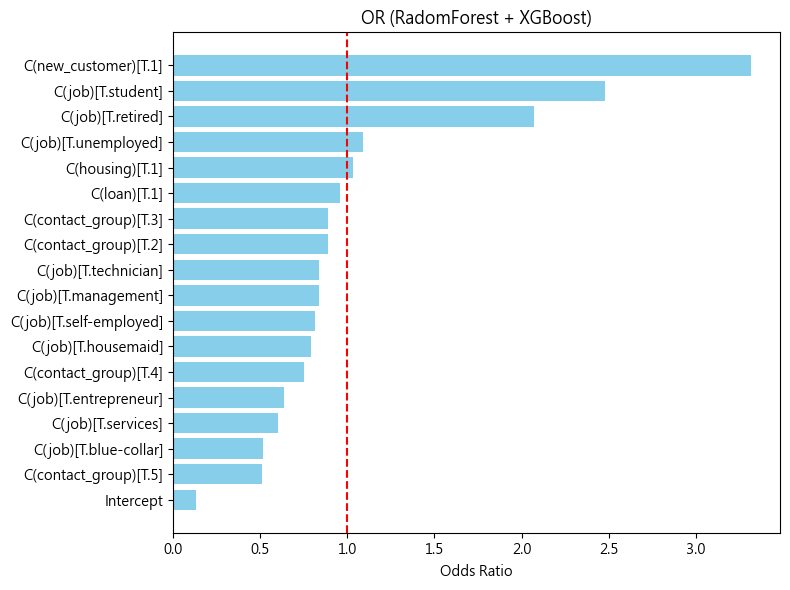

In [21]:
#抓出隨機森林跟XGBoost前十名中重複較多的變數做邏輯斯回歸
model = smf.logit("time_deposit ~ C(job) + C(loan) + C(housing) + C(contact_group) + C(new_customer)",data = df).fit()
print(model.summary())

coef_table = pd.DataFrame({
    'coef': model.params,
    'OR' : np.exp(model.params)}).reindex(model.params.abs().sort_values(ascending = False).index)
print(coef_table.sort_values(by = 'OR',ascending = False))

coef = model.params
odds_ratio = np.exp(coef)
summary_df = pd.DataFrame({
    'variable' : coef.index,
    'coefficient' : coef.values,
    'OR' : odds_ratio.values}).sort_values(by = 'OR' ,ascending = False)
plt.figure(figsize = (8,6))
plt.barh(summary_df['variable'],summary_df['OR'],color = 'skyblue')
plt.axvline(x = 1,color = 'red',linestyle = '--')
plt.xlabel('Odds Ratio')
plt.title('OR (RadomForest + XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Logistic Regression - OR(RandomForest + XGBoost)')
plt.show()


Optimization terminated successfully.
         Current function value: 0.314428
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           time_deposit   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41169
Method:                           MLE   Df Model:                           18
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                  0.1068
Time:                        00:19:24   Log-Likelihood:                -12951.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.6125      0.058    -27.899      0.000      

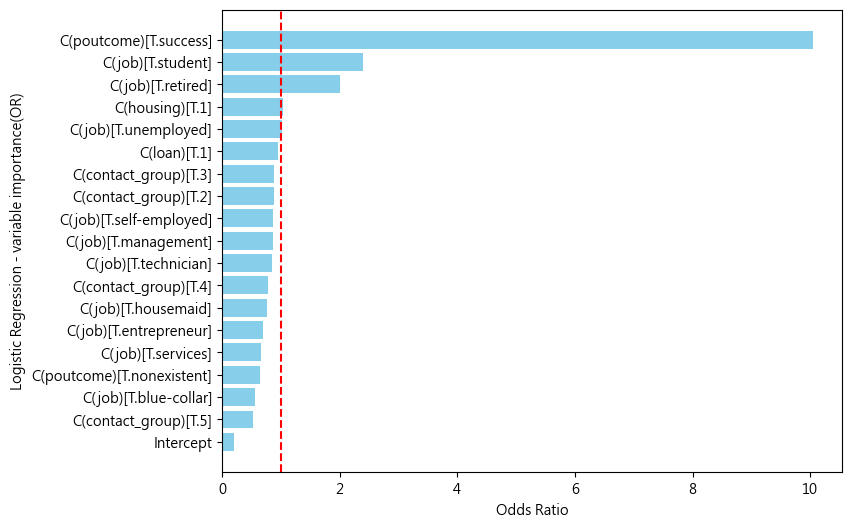

In [22]:
#結合隨機森林、XGBoost跟邏輯斯回歸最重要變數的版本(刪除new_customer是因為跟poutcome有高度共線性)
model = smf.logit("time_deposit ~ C(job) + C(loan) + C(housing) + C(contact_group)  + C(poutcome)",data = df).fit()
print(model.summary())

coef_table = pd.DataFrame({
    'coef' : model.params,
    'OR' : np.exp(model.params)}).reindex(model.params.abs().sort_values(ascending = False).index)
print(coef_table.sort_values(by = 'OR',ascending = False))


coef = model.params
odds_ratio = np.exp(coef)
summary_df = pd.DataFrame({
    'variable' : coef.index,
    'coefficient' : coef.values,
    'OR' : odds_ratio.values}).sort_values(by = 'OR',ascending = False)
plt.figure(figsize = (8,6))
plt.barh(summary_df['variable'],summary_df['OR'],color = 'skyblue')
plt.axvline(x = 1,color = 'red',linestyle = '--')
plt.xlabel('Odds Ratio')
plt.ylabel('Logistic Regression - variable importance(OR)')
plt.gca().invert_yaxis()
plt.show()


Optimization terminated successfully.
         Current function value: 0.306841
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           time_deposit   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41169
Method:                           MLE   Df Model:                           18
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                  0.1284
Time:                        00:19:25   Log-Likelihood:                -12638.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1073      0.218     -5.078      0.000      

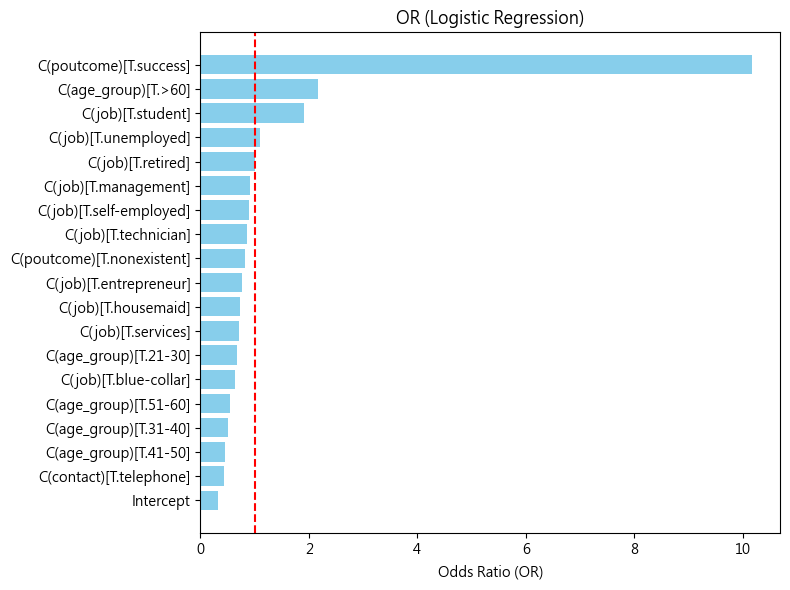

In [23]:
#抓出邏輯斯回歸中R-square前五的變數
logistic = smf.logit('time_deposit ~ C(age_group) + C(contact) + C(poutcome) + C(job)',data = df).fit()
print(logistic.summary())
coef_table = pd.DataFrame({
    'coef' : logistic.params,
    'OR' : np.exp(logistic.params)}).reindex(logistic.params.abs().sort_values(ascending = False).index)
print(coef_table.sort_values(by = 'OR',ascending = False))

# 抓出係數與 OR
coef = logistic.params
odds_ratio = np.exp(coef)

# 組成 DataFrame，方便排序
summary_df = pd.DataFrame({
    "Variable": coef.index,
    "Coefficient": coef.values,
    "OR": odds_ratio.values
}).sort_values(by="OR", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(summary_df["Variable"], summary_df["OR"], color="skyblue")
plt.axvline(x=1, color="red", linestyle="--")  # OR=1 參考線
plt.xlabel("Odds Ratio (OR)")
plt.title("OR (Logistic Regression)")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('Logistic Regression - OR(Logistic)')
plt.show()

In [24]:
#檢查共線性
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_encode = pd.get_dummies(df, drop_first = True)
df_encode = df_encode.astype(float)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_encode.values, i) for i in range(df_encode.shape[1])]
vif['feature'] = df_encode.columns
print(vif.sort_values('VIF', ascending=False))

           VIF                        feature
29  374.794218           poutcome_nonexistent
32   87.278646                age_group_31-40
33   77.174108                age_group_41-50
6    64.388954                   new_customer
34   62.163633                age_group_51-60
31   49.449367                age_group_21-30
35   14.740029                  age_group_>60
0    13.508872                            age
4     4.787251                       previous
25    4.106588    education_university.degree
22    3.390772          education_high.school
19    2.935985                 marital_single
24    2.693295  education_professional.course
18    2.576627                marital_married
7     2.473673                  contact_group
3     2.472721                  contact_count
8     2.258487                job_blue-collar
21    2.252308             education_basic.9y
12    1.756390                    job_retired
16    1.724402                 job_technician
20    1.517567             educati

In [25]:
df

,age,job,marital,education,default,housing,loan,contact,contact_count,previous,poutcome,time_deposit,age_group,new_customer,contact_group
0,56,housemaid,married,basic.4y,no,0,0,telephone,1,0,nonexistent,0,51-60,0,1
1,57,services,married,high.school,unknown,0,0,telephone,1,0,nonexistent,0,51-60,0,1
2,37,services,married,high.school,no,1,0,telephone,1,0,nonexistent,0,31-40,0,1
3,40,admin.,married,basic.6y,no,0,0,telephone,1,0,nonexistent,0,31-40,0,1
4,56,services,married,high.school,no,0,1,telephone,1,0,nonexistent,0,51-60,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,1,0,cellular,1,0,nonexistent,1,>60,0,1
41184,46,blue-collar,married,professional.course,no,0,0,cellular,1,0,nonexistent,0,41-50,0,1
41185,56,retired,married,university.degree,no,1,0,cellular,2,0,nonexistent,0,51-60,0,2
41186,44,technician,married,professional.course,no,0,0,cellular,1,0,nonexistent,1,41-50,0,1


In [26]:
pd.read_excel("bank data.xlsx")

,age,job,marital,education,default,housing,loan,contact,contact_count,previous,poutcome,time_deposit,age_group,new_customer,contact_group
0,56,housemaid,married,basic.4y,no,0,0,telephone,1,0,nonexistent,0,51-60,0,1
1,57,services,married,high.school,unknown,0,0,telephone,1,0,nonexistent,0,51-60,0,1
2,37,services,married,high.school,no,1,0,telephone,1,0,nonexistent,0,31-40,0,1
3,40,admin.,married,basic.6y,no,0,0,telephone,1,0,nonexistent,0,31-40,0,1
4,56,services,married,high.school,no,0,1,telephone,1,0,nonexistent,0,51-60,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,1,0,cellular,1,0,nonexistent,1,>60,0,1
41184,46,blue-collar,married,professional.course,no,0,0,cellular,1,0,nonexistent,0,41-50,0,1
41185,56,retired,married,university.degree,no,1,0,cellular,2,0,nonexistent,0,51-60,0,2
41186,44,technician,married,professional.course,no,0,0,cellular,1,0,nonexistent,1,41-50,0,1
